# Dataset Exploration

This notebook contains

1. Loading and cleaning the dataset into a DataFrame
2. Exploratory Analysis

## 0. Importing all necessary packages

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn as skl

## 1. Loading the dataset into a DataFrame

Defining important variables

In [27]:
# download from https://drive.google.com/file/d/1f1DvjpOt31YZUPeRe3_tszGdDtyY6dK2/view?usp=share_link to content
# upload to local runtime
DS_PATH_DRIVE = '/content/EPINetz_TwitterPoliticians_2021.csv'
DS_PATH_LOCAL = 'data/EPINetz_TwitterPoliticians_2021.csv'


First the data is loaded from the file and then it is anonymized by eliminating the fields that are more related to the identity of a person. These fields will be irrelevant in our analysis.

The only id that will be kept is the __user_id__ to keep the relationship to Twitter.

The __until__ field will be dropped too, as every person in the list is currently in the German government.

In [29]:
try:
  df = pd.read_csv(DS_PATH_LOCAL)
except FileNotFoundError:
  df = pd.read_csv(DS_PATH_DRIVE)

df.drop(columns=['ID', 'until', 'abgeordnetenwatch_id', 'official_name', 'twitter_name', 'twitter_handle', 'wikidata_id'], inplace=True)
df.dropna(axis=0,how='any', inplace=True)

df = df.astype(
    {
        'year_of_birth':'int',
        'user_id': 'int'
        }
    )
df['from'] = pd.DatetimeIndex(df['from']).year

df.head()

,party,region,institution,office,user_id,from,year_of_birth,gender
0,SPD,Brandenburg,State Parliament,Parliamentarian,827090742162100224,2019,1976,female
1,DIE LINKE,Federal,Federal Parliament,Parliamentarian,1683845126,2017,1963,female
2,SPD,Federal,Federal Parliament,Parliamentarian,1377117206,2017,1973,female
3,FDP,Schleswig-Holstein,State Parliament,Parliamentarian,1073605033,2017,1961,male
4,DIE LINKE,Federal,Federal Parliament,Parliamentarian,551802475,2017,1965,female


## 2. Exploratory Analysis

The following analysis will be done to the data coming from the parties that most officials belong to.

In [19]:
majority_threshold = 50 # officials
parties = df.groupby(['party'])['user_id'].count().sort_values(ascending=False)

majority_parties = list(parties.loc[parties > majority_threshold].index)

majority_df = df.loc[df['party'].isin(majority_parties)].copy()

For the analysis of the data, the independent and dependent variables need to be separated.

The __independent variables__ are the _inputs_ that serve as the data that points to the origin of a particular politician. Such variables are:
- __Gender__: Gender is always on the look as some people may be more likely (not) to vote for a person of a particular gender for a particular office.
- __Age__: Sometimes the age is related to the openness to new ideas, which means that it may be crucial to predict the possible ideology of a person and whether it will be voted for a particular position.
- __Election Year__: When whas the official elected?

The following are defined as the __dependent variables__ as they are the _outcomes_ to predict:
- __Institution__: To which institution will someone be elected to work at?
- __Office__: Which office will someone be elected to hold?
- __Party__: Which party will someone join?
- __Region__: Where was the official elected?.

The last two can be used as inputs as well, as they become circumstances related to the result of the first two.



In [20]:
def scatter_dependent(col: str):
    majority_df.plot(kind='scatter', x=col, y='institution')
    majority_df.plot(kind='scatter', x=col, y='office')
    majority_df.plot(kind='scatter', x=col, y='region')
    majority_df.plot(kind='scatter', x=col, y='party')

def table_dependent(col: str):
    display(majority_df.groupby(['institution', col])['user_id'].count())
    display(majority_df.groupby(['office', col])['user_id'].count())
    display(majority_df.groupby(['region', col])['user_id'].count())
    display(majority_df.groupby(['party', col])['user_id'].count())

    

The following is the officials' distribution according to their gender.

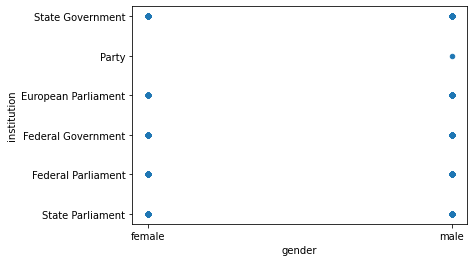

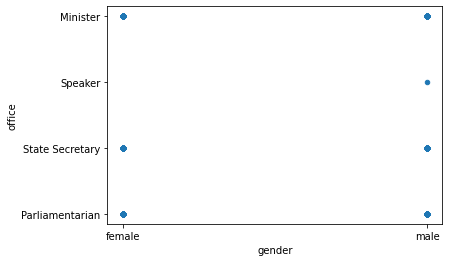

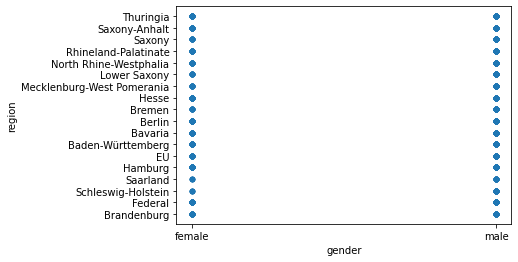

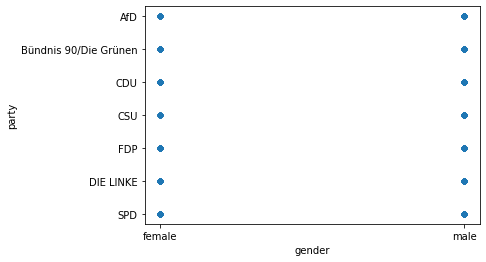

In [21]:
scatter_dependent('gender')

The scatter plots show that nearly every party, region, office and institution has a member of each gender. Next the quantity is analyzed in the following tables

In [22]:
table_dependent('gender')

institution          gender
European Parliament  female     28
                     male       44
Federal Government   female     36
                     male       49
Federal Parliament   female    281
                     male      530
Party                male        1
State Government     female     89
                     male      132
State Parliament     female    402
                     male      816
Name: user_id, dtype: int64

office           gender
Minister         female      73
                 male        79
Parliamentarian  female     711
                 male      1390
Speaker          male         1
State Secretary  female      52
                 male       102
Name: user_id, dtype: int64

region                      gender
Baden-Württemberg           female     34
                            male       79
Bavaria                     female     34
                            male       71
Berlin                      female     78
                            male      128
Brandenburg                 female     29
                            male       33
Bremen                      female     18
                            male       40
EU                          female     28
                            male       44
Federal                     female    317
                            male      580
Hamburg                     female     49
                            male       56
Hesse                       female     42
                            male       67
Lower Saxony                female     19
                            male       49
Mecklenburg-West Pomerania  female     22
                            male       37
North Rhine-Westphalia      female     30

party                  gender
AfD                    female     32
                       male      235
Bündnis 90/Die Grünen  female    247
                       male      216
CDU                    female    112
                       male      373
CSU                    female     26
                       male       71
DIE LINKE              female    116
                       male      101
FDP                    female     57
                       male      184
SPD                    female    246
                       male      392
Name: user_id, dtype: int64

As it is shown in the table, male officers are often the majority across all positions and institutions, with little exceptions in the parties.

Next it is performed the distribution anlaysis on regarding the age (year of birth) of the officials. In this case distribution is the only analysis that matters because the data is very sparse

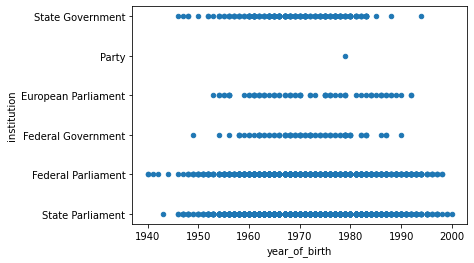

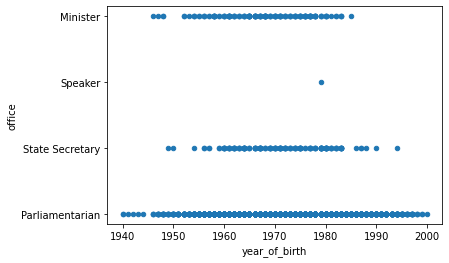

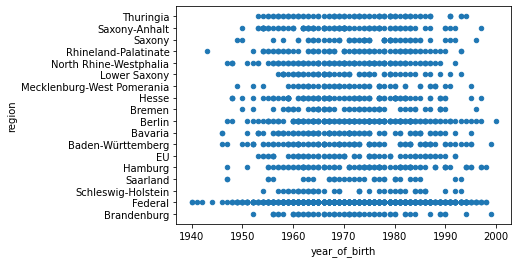

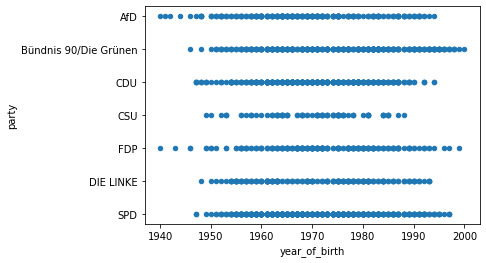

In [23]:
scatter_dependent('year_of_birth')

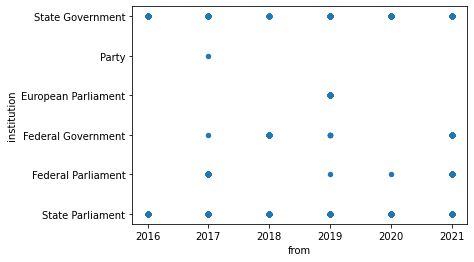

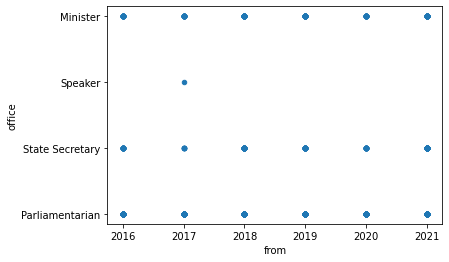

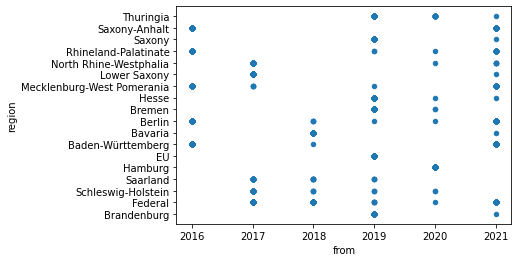

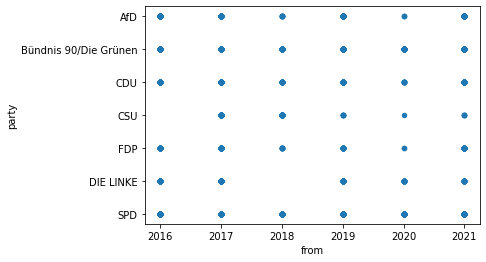

In [24]:
scatter_dependent('from')